## Results of the modified FOMO models

the dense architacture is neglected due to wrong implementation

In [14]:
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import re
import tensorflow as tf

In [15]:
with open("results.yaml", "r") as f:
    data = yaml.safe_load(f)


### First, plot the results

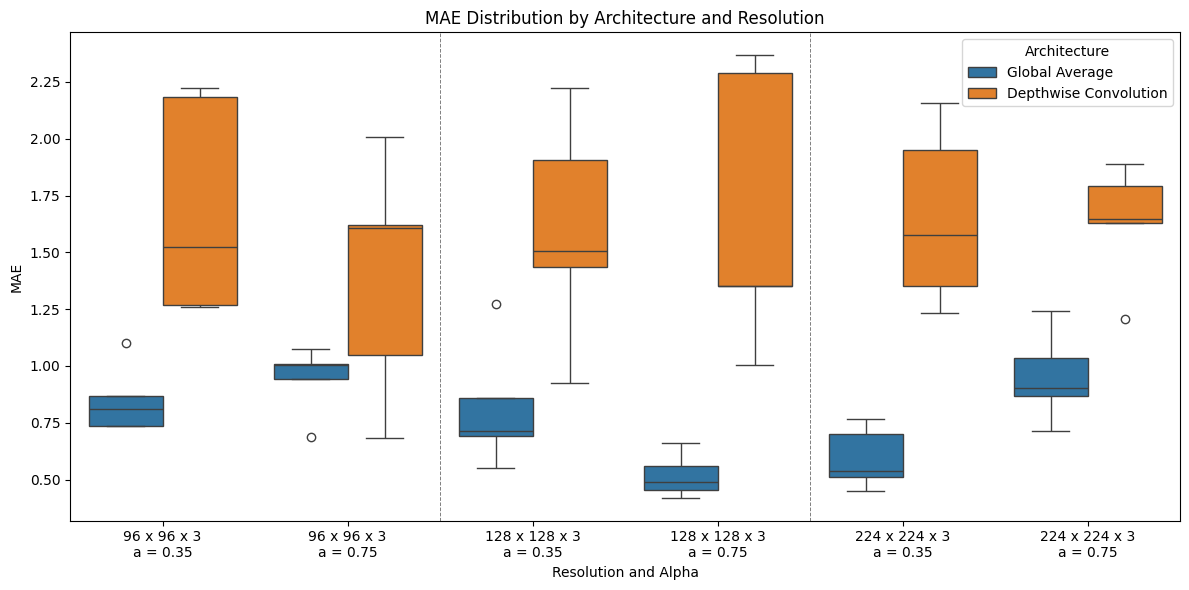

In [16]:
records = []
for key, metrics in data.items():
    mae = metrics.get("mae")
    if mae is None:
        continue
    parts = key.split("_")
    architecture = parts[2]
    resolution = parts[3]
    alpha = parts[4]
    records.append({
        "Architecture": architecture,
        "Resolution": resolution,
        "Alpha": alpha,
        "MAE": mae,
        "name": key
    })

df = pd.DataFrame(records)

# Rename architecture labels
df["Architecture"] = df["Architecture"].replace({
    "gap": "Global Average",
    "dense": "Dense Layers",
    "depth": "Depthwise Convolution"
})

# ❌ Remove all "Dense Layers" entries
df = df[df["Architecture"] != "Dense Layers"]

# Label for x-axis
df["Label"] = df.apply(
    lambda row: f"{row['Resolution'].replace('r', '')} x {row['Resolution'].replace('r', '')} x 3\na = {row['Alpha'].replace('a0', '0.')}",
    axis=1
)

# Resolution ordering for sorting
resolution_order = ['r96', 'r128', 'r224']
df["ResOrder"] = df["Resolution"].apply(lambda r: resolution_order.index(r))

df_sorted = df.sort_values(by=["ResOrder", "Alpha"])
label_order = df_sorted["Label"].unique()

# Plot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x="Label", y="MAE", hue="Architecture", data=df_sorted, order=label_order)

plt.ylabel("MAE")
plt.xlabel("Resolution and Alpha")
plt.title("MAE Distribution by Architecture and Resolution")

# Vertical separators between resolution groups
prev_res = None
for i, label in enumerate(label_order):
    res = label.split(" ")[0]
    if prev_res is not None and res != prev_res:
        plt.axvline(i - 0.5, color='gray', linestyle='--', linewidth=0.7)
    prev_res = res

plt.tight_layout()
plt.legend(title="Architecture")
plt.show()


In [17]:
loss_summary = (
    df.groupby(['Architecture', 'Resolution', 'Alpha'])['MAE']
      .agg(['median', 'min', 'max'])
      .reset_index()
)

# Pivot for cleaner view (one table per metric per architecture)
summary_pivot = loss_summary.pivot_table(
    index=['Resolution'],
    columns=['Alpha', 'Architecture'],
    values=['median', 'min', 'max']
).round(4)

# Optional: re-order columns nicely
summary_pivot = summary_pivot.sort_index(axis=1, level=[0, 1])

# Display
import pandas as pd
with pd.option_context('display.max_columns', None):
    display(summary_pivot)

max                                       \
Alpha                         a035                                 a075   
Architecture Depthwise Convolution Global Average Depthwise Convolution   
Resolution                                                                
r128                        2.2219         1.2725                2.3705   
r224                        2.1589         0.7670                1.8879   
r96                         2.2240         1.1020                2.0075   

                                           median                 \
Alpha                                        a035                  
Architecture Global Average Depthwise Convolution Global Average   
Resolution                                                         
r128                 0.6626                1.5057         0.7151   
r224                 1.2400                1.5775         0.5365   
r96                  1.0765                1.5219         0.8120   

                                                                    min  \
Alpha                         a075                                 a035   
Architecture Depthwise Convolution Global Average Depthwise Convolution   
Resolution                                                                
r128                        1.3537         0.4908                0.9257   
r224                        1.6464         0.9016                1.2348   
r96                         1.6084         1.0036                1.2590   

                                                                  
Alpha                                        a075                 
Architecture Global Average Depthwise Convolution Global Average  
Resolution                                                        
r128                 0.5515                1.0032         0.4172  
r224                 0.4491                1.2058         0.7129  
r96                  0.7338                0.6842         0.6891

### Now let's look at some GRAD-CAMS

save the models that had the meadian loss value

In [ ]:
#see wich version is the median

median_losses = df.groupby(['Resolution', 'Alpha', "Architecture"])['MAE'].median().reset_index()
median_losses.rename(columns={'MAE': 'median_val_loss'}, inplace=True)


merged = pd.merge(df, median_losses, on=['Resolution', 'Alpha', "Architecture"])


median_models = merged[merged['MAE'] == merged['median_val_loss']][['Resolution', 'Alpha', 'name', 'MAE', "Architecture"]]


median_models.sort_values(by=['Resolution', 'Alpha', "Architecture"])

lijst = median_models.name.to_list()
lijst

['fomo_count_depth_r96_a075_0',
 'fomo_count_gap_r96_a075_1',
 'fomo_count_depth_r128_a035_1',
 'fomo_count_depth_r96_a035_2',
 'fomo_count_depth_r224_a035_2',
 'fomo_count_depth_r128_a075_2',
 'fomo_count_gap_r128_a075_3',
 'fomo_count_gap_r224_a075_3',
 'fomo_count_depth_r224_a075_3',
 'fomo_count_gap_r96_a035_4',
 'fomo_count_gap_r128_a035_4',
 'fomo_count_gap_r224_a035_4']

In [ ]:
#select two models to visualize

model_depth = tf.keras.models.load_model("out_m/fomo_count_depth_r128_a075_2.keras")
model_gap = tf.keras.models.load_model("out_m/fomo_count_gap_r128_a075_3.keras")

#### Function to create GRADCAM and helper function to visualize

In [20]:
import numpy as np
def get_img_array(path, res):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.resize(image, (res, res))
    casted = tf.cast(image, tf.float32) / 255.0

    array = tf.keras.utils.img_to_array(casted)
    array = np.expand_dims(array, axis=0)

    return array, image

In [ ]:
#official function from the keras docs

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

import cv2

def overlay_heatmap(heatmap, image, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    overlayed = heatmap_color * alpha + image
    return np.uint8(overlayed)

def upscale_heatmap(heatmap, res=128):
    return cv2.resize(heatmap, (res, res))

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def img_is_color(img):
    if len(img.shape) == 3:
        c1, c2, c3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return False
        return True
    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2,
                    figsize=(20, 10), title_fontsize=30, show_colorbar=False):
    assert isinstance(list_images, list) and len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images = len(list_images)
    num_cols = min(num_images, num_cols)
    num_rows = int(np.ceil(num_images / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    if not isinstance(axes, np.ndarray):
        list_axes = [axes]
    else:
        list_axes = list(axes.flat)

    for i in range(num_images):
        img = list_images[i]
        title = list_titles[i] if list_titles is not None else f'Image {i}'
        cmap = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')

        im = list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize)
        list_axes[i].grid(grid)

        # Add colorbar only if image is not RGB and show_colorbar is True
        if show_colorbar and (cmap is not None):
            plt.colorbar(im, ax=list_axes[i], fraction=0.046, pad=0.04)

    # Hide unused subplots
    for i in range(num_images, len(list_axes)):
        list_axes[i].axis('off')

    fig.tight_layout()
    plt.show()


#### Visualize

c:\Users\Xander Verberckt\Documents\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_52']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)
c:\Users\Xander Verberckt\Documents\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_10']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


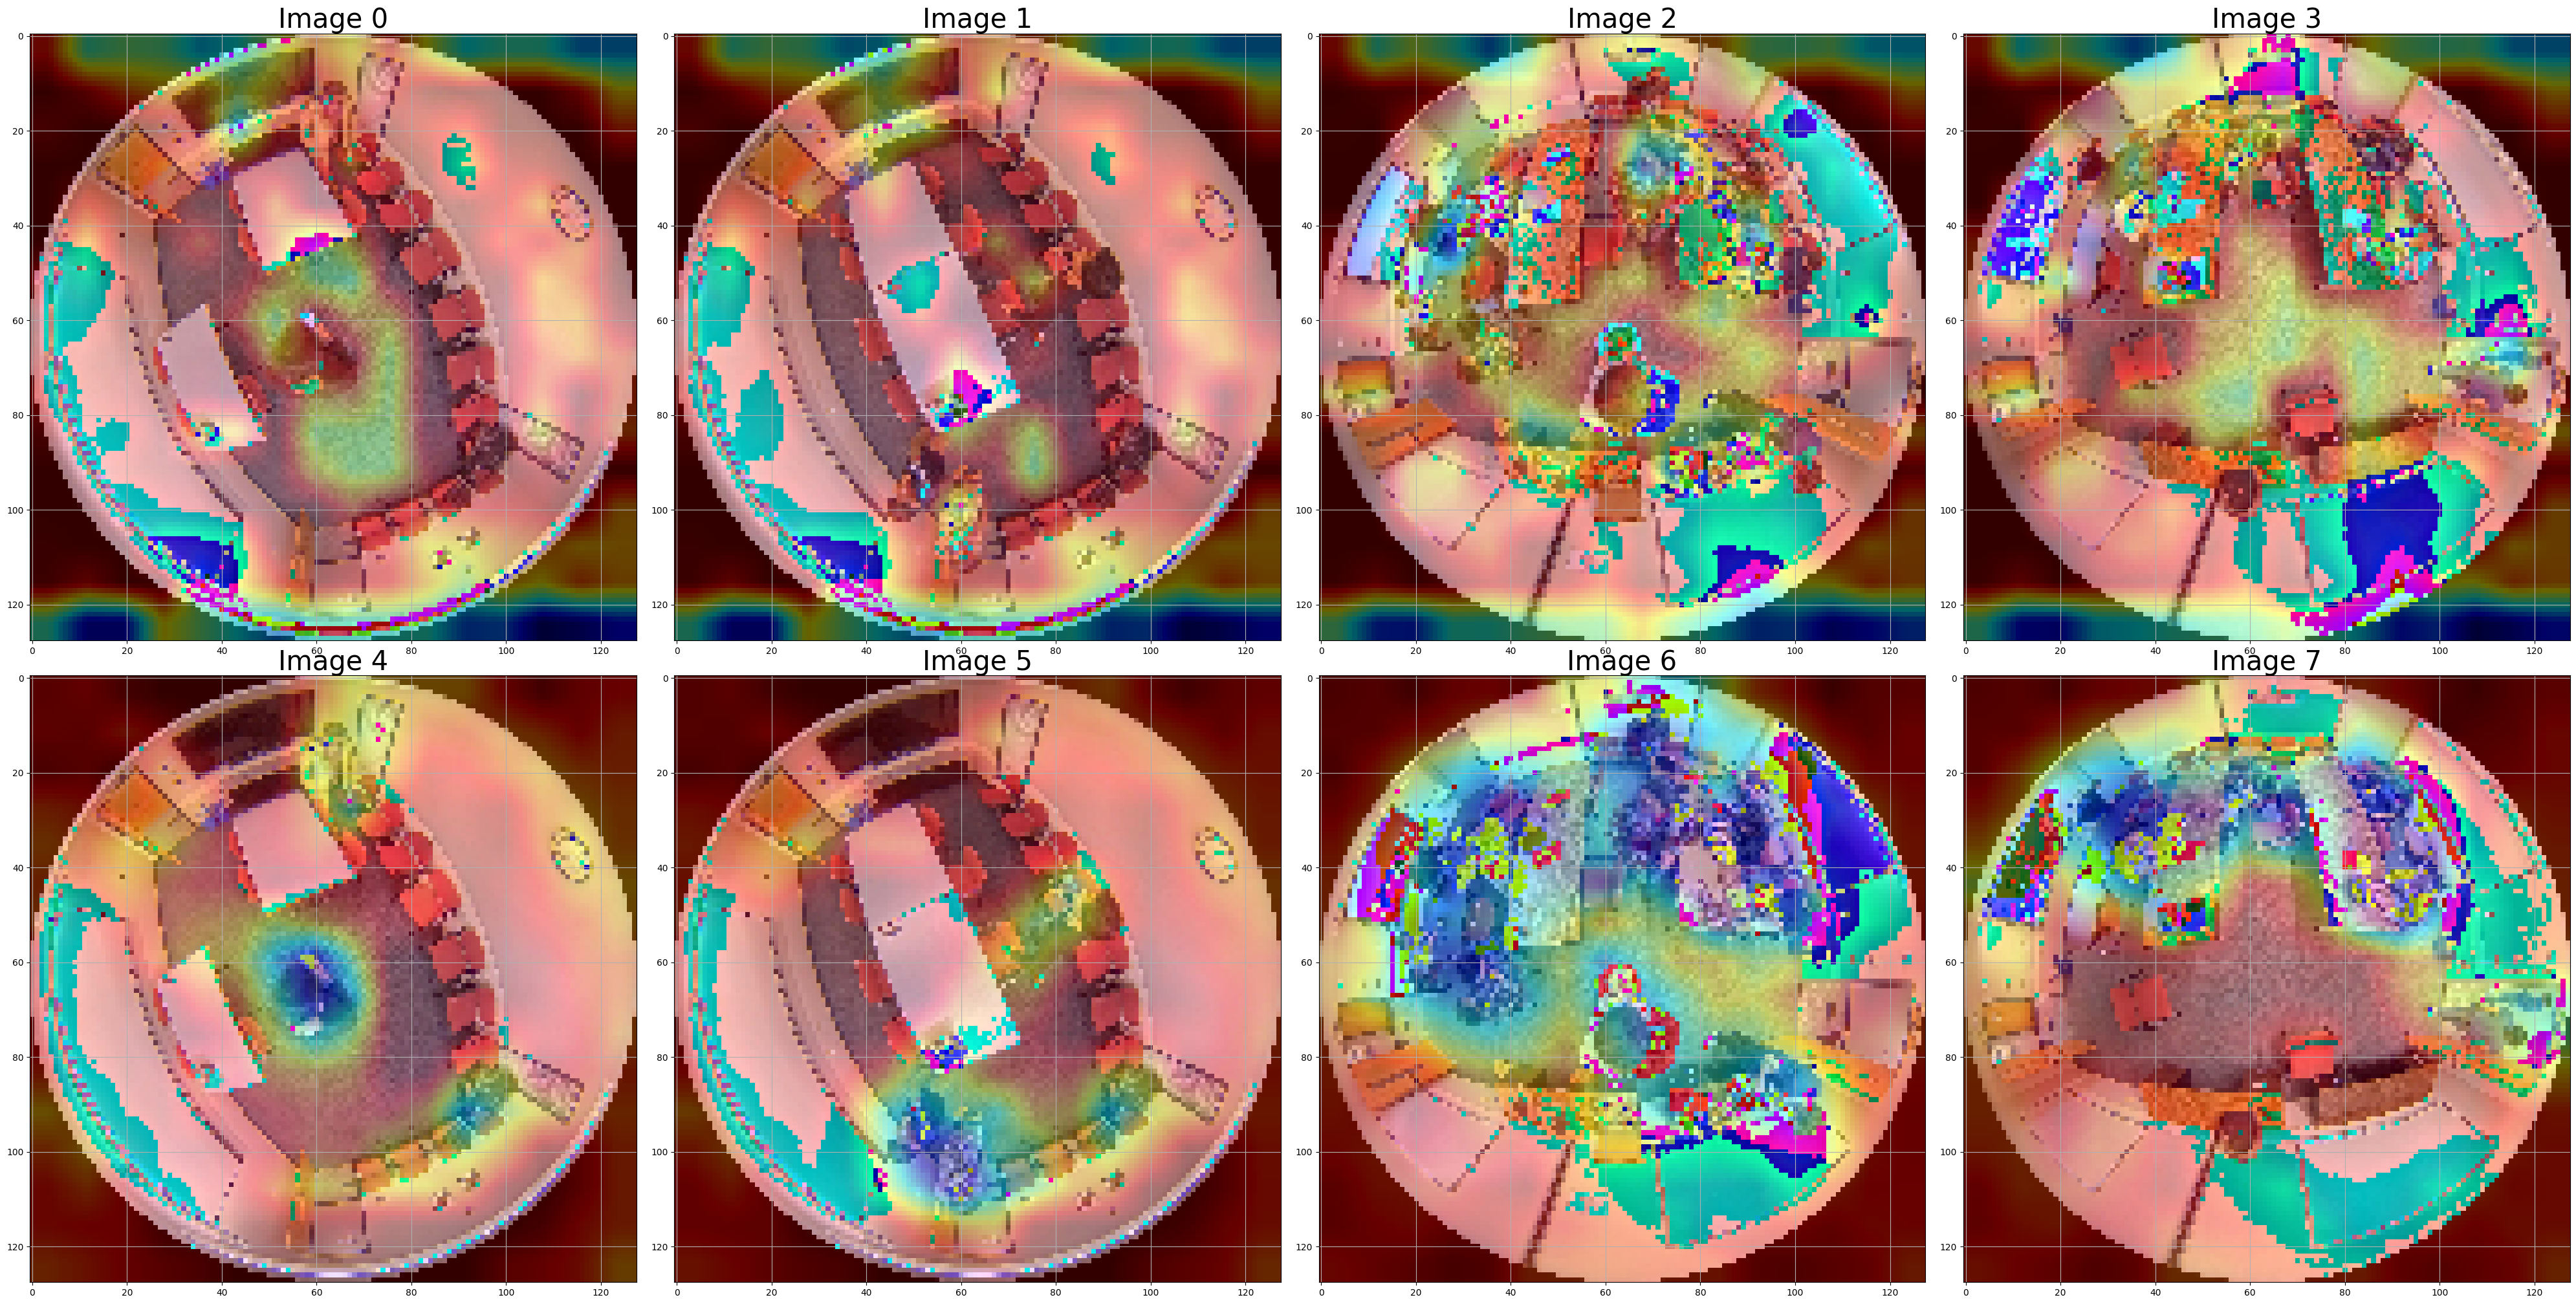

In [ ]:
last_conv_layer = "logits"
images = ["../../dataset/hc/val/images/Meeting1_000201.jpg",
          "../../dataset/hc/val/images/Meeting2_000441.jpg",
          "../../dataset/hc/val/images/Lunch2_001441.jpg",
          "../../dataset/hc/val/images/Lunch3_000521.jpg",
          ]

out_models = []
out_names = []

for img in images:

    arr, img = get_img_array(img, 128)

    heatmap_depth = make_gradcam_heatmap(arr, model_depth, last_conv_layer)

    out_models.append(overlay_heatmap(heatmap_depth, img))
    #out_names.append(f"Depthwise convolution")

for img in images:

    arr, img = get_img_array(img, 128)

    heatmap_gap = make_gradcam_heatmap(arr, model_gap, last_conv_layer)
    
    out_models.append(overlay_heatmap(heatmap_gap, img))
    #out_names.append(f"Global average pooling")

print("Top row = depthwise conv modification, bottom row = GAP modification")
show_image_list(out_models, figsize=(40, 20), num_cols=4, show_colorbar=True)

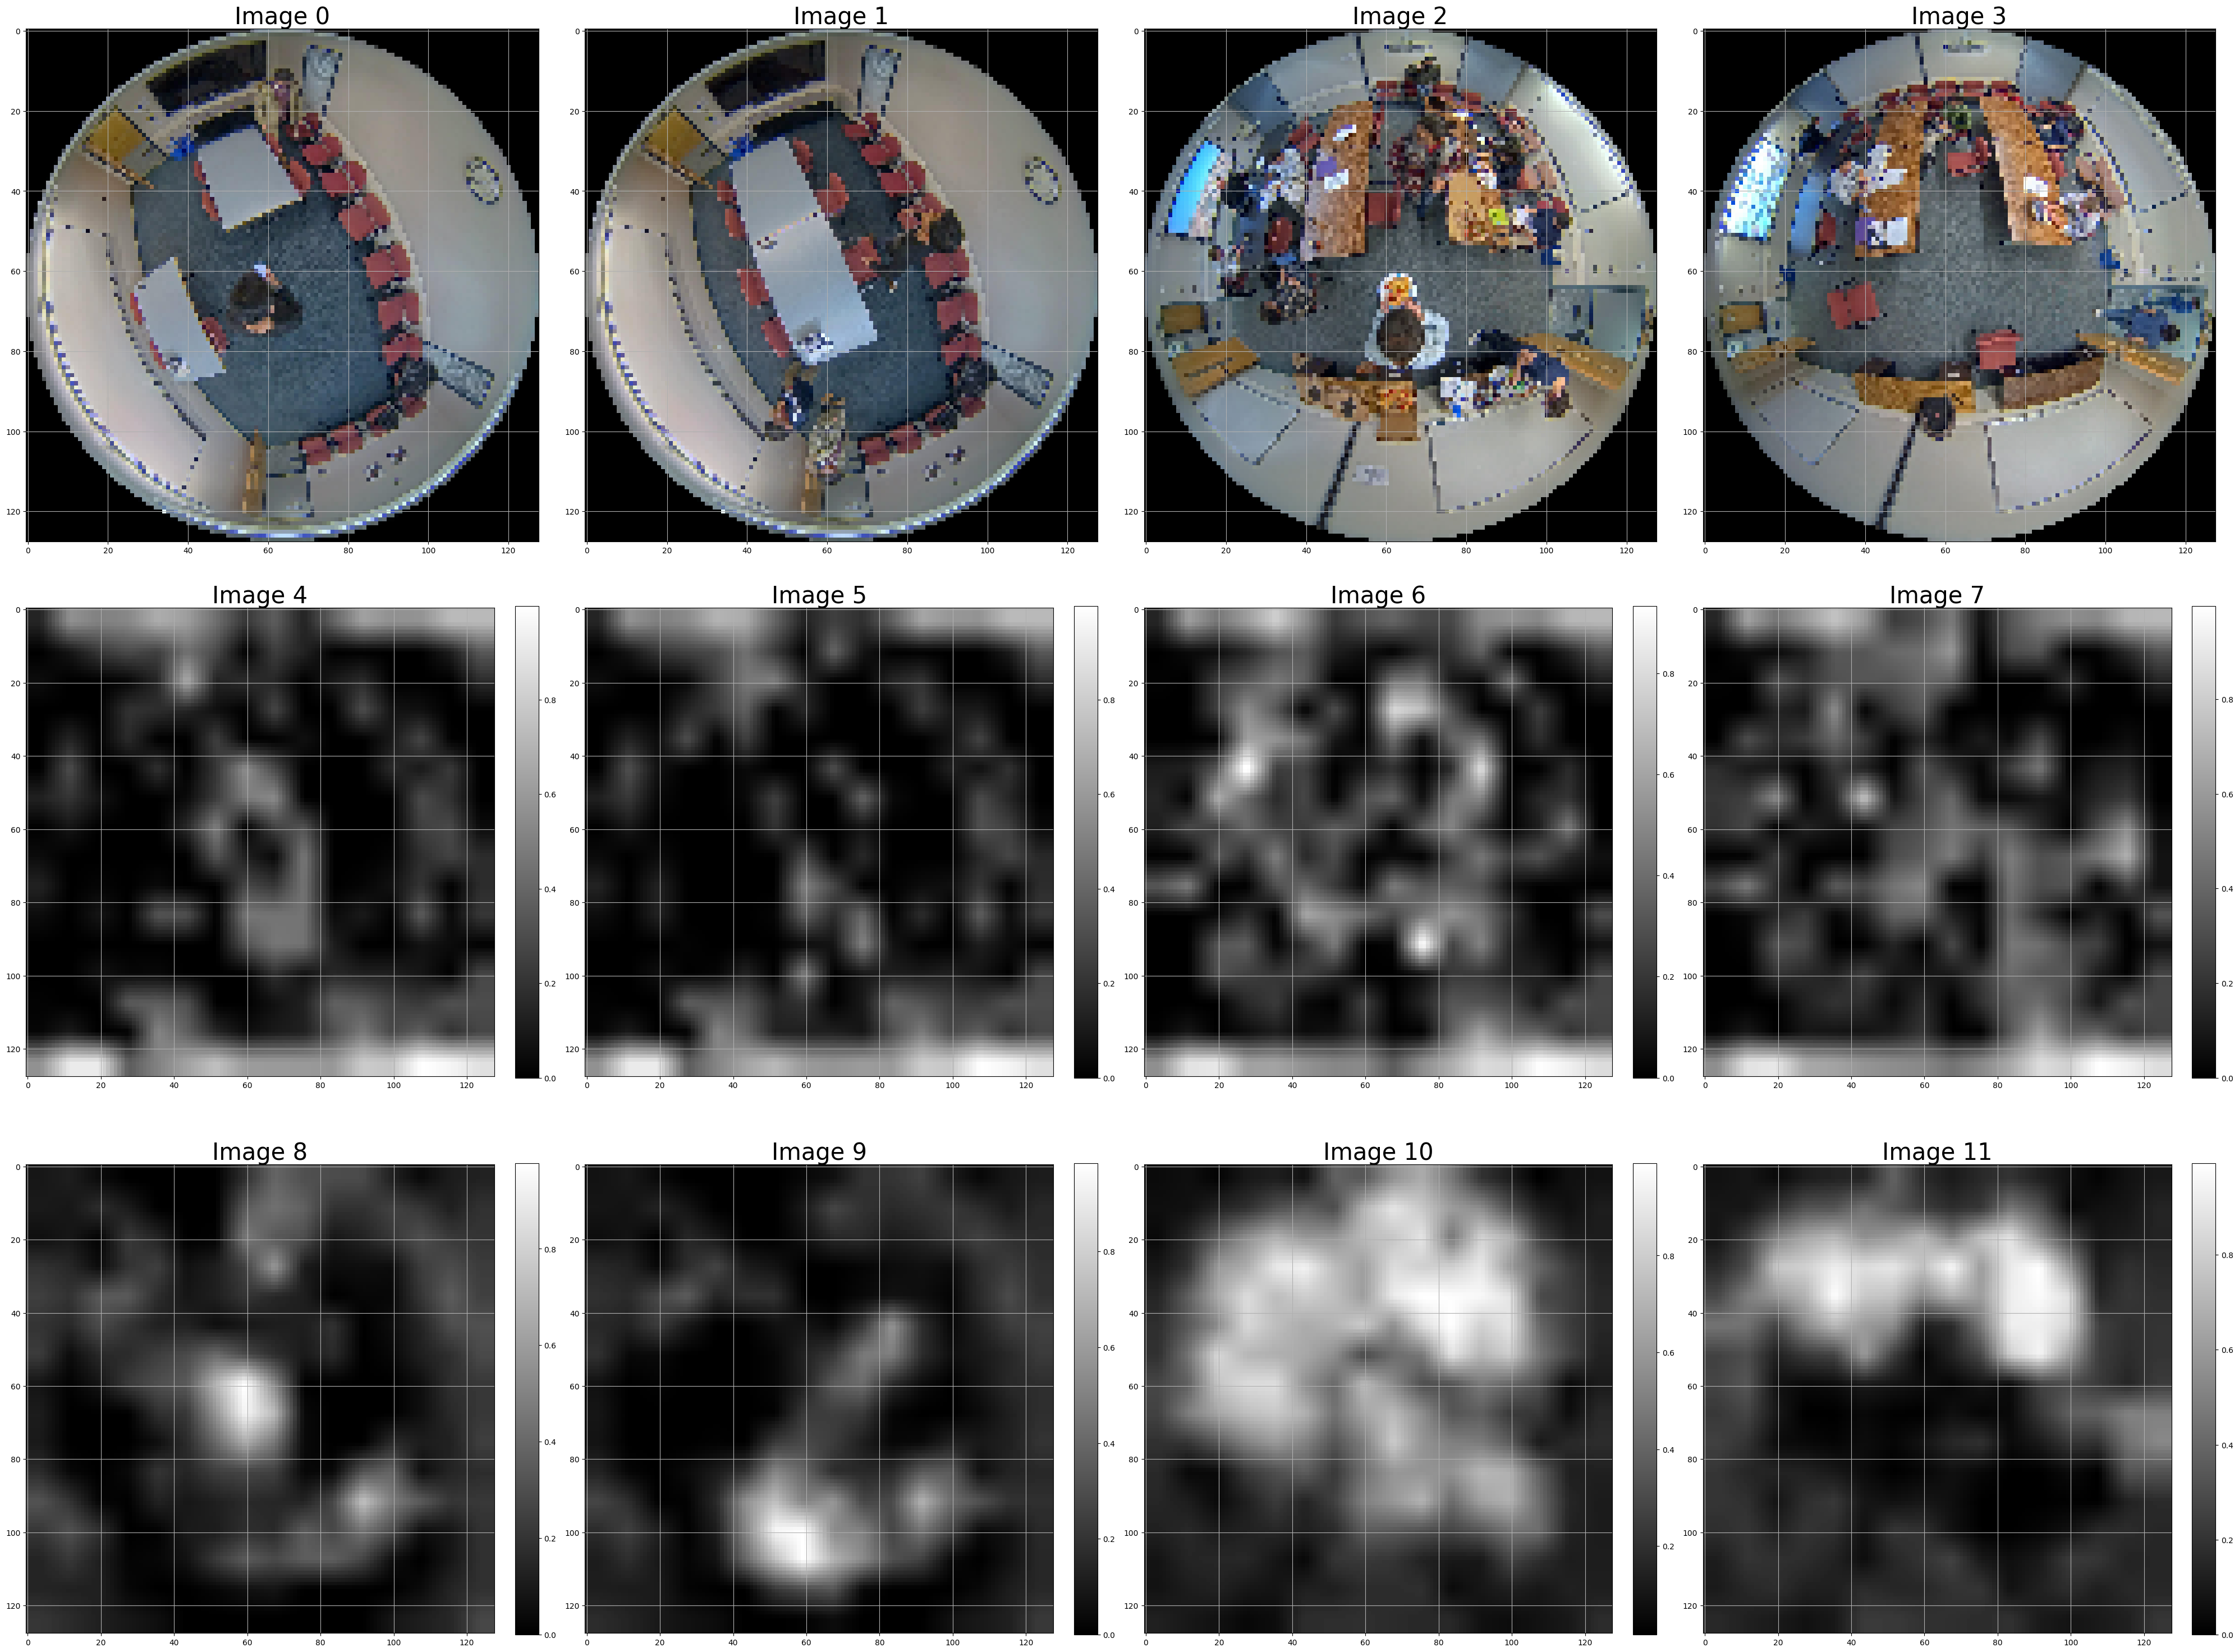

In [ ]:
last_conv_layer = "logits"
images = ["../../dataset/hc/val/images/Meeting1_000201.jpg",
          "../../dataset/hc/val/images/Meeting2_000441.jpg",
          "../../dataset/hc/val/images/Lunch2_001441.jpg",
          "../../dataset/hc/val/images/Lunch3_000521.jpg",
          ]

out_models = []
out_names = []

for img in images:
    arr, img = get_img_array(img, 128)
    out_models.append(np.uint8(img))

for img in images:

    arr, img = get_img_array(img, 128)

    heatmap_depth = make_gradcam_heatmap(arr, model_depth, last_conv_layer)

    out_models.append(upscale_heatmap(heatmap_depth))

for img in images:

    arr, img = get_img_array(img, 128)

    heatmap_gap = make_gradcam_heatmap(arr, model_gap, last_conv_layer)
    
    out_models.append(upscale_heatmap(heatmap_gap))
    #out_names.append(f"Global average pooling")

show_image_list(out_models, figsize=(40, 30), num_cols=4, show_colorbar=True)

#### Convert to tflite

slected models are:
- fomo_count_gap_r96_a075_1
- fomo_count_gap_r96_a035_4
- fomo_count_gap_r128_a075_3
- fomo_count_gap_r128_a035_4

In [ ]:
import sys

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)

from DatasetLoader import DatasetLoader as dl

def get_dataset(data):
    dl_loaders =[]
    datasets = []
    ds = []
    for i in [96, 128, 224]:
        dl_loaders.append(dl("RGB", "count", i))
        dataset, c = dl_loaders[-1].create_dataset_count(data)
        datasets.append(dataset)
        ds.append((datasets[-1]         
                .map(lambda f, c: dl_loaders[-1].get_sample(f, c, train=False), 
                    num_parallel_calls=tf.data.AUTOTUNE)
                .batch(35)                          
                .prefetch(tf.data.AUTOTUNE)))
        
    return ds

ds = get_dataset("validate")

In [19]:

# function to transform to cpp file:

def to_cpp(tflite_model, tflite_filename, define_name):
    cpp_filename = tflite_filename.replace('.tflite', '.cpp')
    with open(cpp_filename, "w") as f:
        var_name = tflite_filename.replace(".", "_")  # Generate a variable name from the file
        f.write('#include "model.h"\n\n')
        f.write(f'#ifdef {define_name}\n\n')
        f.write("const unsigned char model_data[] = {")

        for i, b in enumerate(tflite_model):
            if i % 12 == 0:  # Break line every 12 bytes like xxd
                f.write("\n    ")
            f.write(f"0x{b:02x}, ")

        f.write("\n};\n")
        f.write(f"const unsigned int model_data_len = {len(tflite_model)};\n")
        f.write(f"#endif    //{define_name}\n")

##### Transform the models

fomo_count_gap_r128_a035_4.keras

In [29]:
def representative_dataset():
  for data in ds[1]:
    yield {
      "input_layer_25": data[0]
    }
tf_model = tf.keras.models.load_model("out_m/fomo_count_gap_r128_a035_4.keras", compile=True)
# tf_model.summary()

#converion for fully int8 quantifier
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

tflite_filename = 'tflite_models/fomo_count_gap_r128_a035_int8.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_quant_model)

to_cpp(tflite_quant_model, tflite_filename, "FOMO_COUNT_GAP_R128_A035_INT8")

INFO:tensorflow:Assets written to: C:\Users\XANDER~1\AppData\Local\Temp\tmpqxz_yo2i\assets


INFO:tensorflow:Assets written to: C:\Users\XANDER~1\AppData\Local\Temp\tmpqxz_yo2i\assets


Saved artifact at 'C:\Users\XANDER~1\AppData\Local\Temp\tmpqxz_yo2i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_25')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2988934398992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988934403600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988934403984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988934403792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988934403216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988934405136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988934405520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988934405904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988934405712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2988934402064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

c:\Users\Xander Verberckt\Documents\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\tensorflow\lite\python\convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
c:\Users\Xander Verberckt\Documents\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


fomo_count_gap_r128_a075_3.keras

In [ ]:
def representative_dataset():
  for data in ds[1]:
    yield {
      "input_layer_10": data[0]
    }
tf_model = tf.keras.models.load_model("out_m/fomo_count_gap_r128_a075_3.keras", compile=True)
# tf_model.summary()

#converion for fully int8 quantifier
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

tflite_filename = 'tflite_models/fomo_count_gap_r128_a075_int8.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_quant_model)

to_cpp(tflite_quant_model, tflite_filename, "FOMO_COUNT_GAP_R128_A075_INT8")

fomo_count_gap_r96_a035_4.keras

In [ ]:
def representative_dataset():
  for data in ds[0]:
    yield {
      "input_layer_24": data[0]
    }
tf_model = tf.keras.models.load_model("out_m/fomo_count_gap_r96_a035_4.keras", compile=True)
# tf_model.summary()

#converion for fully int8 quantifier
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

tflite_filename = 'tflite_models/fomo_count_gap_r96_a035_int8.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_quant_model)

to_cpp(tflite_quant_model, tflite_filename, "FOMO_COUNT_GAP_R96_A035_INT8")

fomo_count_gap_r96_a075_1.keras

In [ ]:
def representative_dataset():
  for data in ds[0]:
    yield {
      "input_layer_27": data[0]
    }
tf_model = tf.keras.models.load_model("out_m/fomo_count_gap_r96_a075_1.keras", compile=True)
# tf_model.summary()

#converion for fully int8 quantifier
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

tflite_filename = 'tflite_models/fomo_count_gap_r96_a075_int8.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_quant_model)

to_cpp(tflite_quant_model, tflite_filename, "FOMO_COUNT_GAP_R96_A075_INT8")

In [ ]:
#transformation that still preserves a float as output and uint8 as input

converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.float32
tflite_quant_model = converter.convert()

### Check performance of quantizes models

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

def evaluate_mae(model_path, image_paths, count_csv_path, res, get_sample_fn, threshold=0.5):
    # Load ground truth counts
    gt_df = pd.read_csv(count_csv_path)
    gt_dict = dict(zip(gt_df['filename'], gt_df['count']))

    abs_errors = []

    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    for img_path in image_paths:
        filename = os.path.basename(img_path)
        gt_count = gt_dict.get(filename, None)

        if gt_count is None:
            print(f"Warning: No ground truth for {filename}")
            continue

        # Preprocess image
        image_tensor = get_sample_fn(img_path, res)
        input_scale, input_zero_point = input_details[0]['quantization']
        image_tensor_quantized = (image_tensor / input_scale + input_zero_point).astype(np.int8)

        interpreter.set_tensor(input_details[0]['index'], image_tensor_quantized)

        interpreter.invoke()

        preds_q = interpreter.get_tensor(output_details[0]['index'])

        output_scale, output_zero_point = output_details[0]['quantization']
        preds = (preds_q.astype(np.float32) - output_zero_point) * output_scale

        abs_errors.append(abs(gt_count - preds))

    mae = np.mean(abs_errors)
    print(f"MAE: {mae:.4f}")
    return mae

In [10]:
def get_sample(path, res):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.resize(image, (res, res))
    image = tf.cast(image, tf.float32) / 255.0

    image = tf.expand_dims(image, axis=0)

    return image.numpy()

In [ ]:
import os
import re

outputs = dict()

tflites = []

for i in os.listdir("tflite_models"):
    if ".tflite" in i:
        tflites.append(f"tflite_models/{i}")

IMG_PATH = "../../dataset/hc/val/images"
CSV_PATH = "../../dataset/hc/val/count.csv"

for i in tflites:
    print(i)
    res = int(re.search("_r\d*", i).group(0).replace("_r", ""))

    image_paths = list(map(lambda x: os.path.join(IMG_PATH, x), os.listdir(IMG_PATH)))
    mae = evaluate_mae(i, image_paths, CSV_PATH, res=res, get_sample_fn=get_sample, threshold=0.5)

    outputs[i] = mae

<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
C:\Users\xande\AppData\Local\Temp\ipykernel_23108\539378232.py:17: SyntaxWarning: invalid escape sequence '\d'
  res = int(re.search("_r\d*", i).group(0).replace("_r", ""))
c:\Users\xande\Documents\kuleuven\MP\MP-person-counting\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


tflite_models/fomo_count_gap_r128_a035_int8.tflite
MAE: 0.7507
tflite_models/fomo_count_gap_r128_a075_int8.tflite


c:\Users\xande\Documents\kuleuven\MP\MP-person-counting\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


MAE: 0.4653
tflite_models/fomo_count_gap_r96_a035_int8.tflite


c:\Users\xande\Documents\kuleuven\MP\MP-person-counting\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


MAE: 1.0060
tflite_models/fomo_count_gap_r96_a075_int8.tflite


c:\Users\xande\Documents\kuleuven\MP\MP-person-counting\MP-Person-counting-on-low-cost-HW\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


MAE: 0.8663


In [20]:
outputs

{'tflite_models/fomo_count_gap_r128_a035_int8.tflite': np.float32(0.7507038),
 'tflite_models/fomo_count_gap_r128_a075_int8.tflite': np.float32(0.46534884),
 'tflite_models/fomo_count_gap_r96_a035_int8.tflite': np.float32(1.0059528),
 'tflite_models/fomo_count_gap_r96_a075_int8.tflite': np.float32(0.8663079)}